<a href="https://colab.research.google.com/github/Sera91/2012-01_Stanford_CS228/blob/master/modified_benchmark_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# K-Nearest Neighbors search

We compare the performances of PyTorch, JAX, KeOps, Scikit-Learn and FAISS (when applicable)
for K-NN queries on random samples and standard datasets.
A detailed discussion of these results can be found in Section 5.2
of our [NeurIPS 2020 paper](https://www.jeanfeydy.com/Papers/KeOps_NeurIPS_2020.pdf).
Generally speaking, generic KeOps routines are orders
of magnitude faster and more memory efficient than
their PyTorch and JAX counterparts.
They perform on par
with the handcrafted CUDA kernels of the FAISS-Flat (bruteforce) method for problems
with **up to 1M samples in dimension 1 to 50-100**,
but are sub-optimal on larger datasets.
Crucially, KeOps is easy to use with **any metric**:
it provides the only competitive run times in the many settings
that are not supported by existing C++ libraries.

In this demo, we often use exact **bruteforce** computations
(tensorized for PyTorch/JAX, on-the-fly for KeOps) and do not leverage any
quantization scheme or multiscale
decomposition of the distance matrix.
First support for these approximation strategies with KeOps is scheduled for
May-June 2021. Going forward, a major priority for KeOps
is to get closer to the reference run times of the FAISS library
in all settings.
We intend to provide a versatile, generic and pythonic code that is easy to
modify and integrate in other projects.
Hopefully, this will **stimulate research on non-Euclidean metrics**,
such as hyperbolic or discrete spaces.

<div class="alert alert-info"><h4>Note</h4><p>Note that timings are always subject to change:
    libraries and hardware get better with time.
    If you find a way of improving these benchmarks, please
    [let us know](https://github.com/getkeops/keops/issues)!</p></div>



## Setup

First, we load some utility routines to run and display benchmarks:



In [1]:
!pip install si_prefix

In [2]:
!pip install multiprocess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.5 MB/s eta 0:00:00


In [5]:
!pip install pykeops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 11.6 MB/s eta 0:00:00
  Created wheel for pykeops: filename=pykeops-2.2.3-py3-none-any.whl size=118636 sha256=96745bbfe4998ad1fe00571857b263eb0e03d26533e26d788dfa0273ea3478e7
  Stored in directory: /root/.cache/pip/wheels/87/7c/b7/bf0e0c414ec6a9cb57d4f638c98e651f4cc115d3bdcecd1bff
  Created wheel for keopscore: filename=keopscore-2.2.3-py3-none-any.whl size=172483 sha256=9a123e055d7a046be9f22da1a4f44d7fff8f261e37485c4d9e25634398f3e46f
  Stored in directory: /root/.cache/pip/wheels/4f/30/66/e08e82125e978761a47296a42998557febc34b08c52b5c8f88
Successfully built pykeops keopscore


In [6]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from functools import partial
from benchmark_utils import (
    full_benchmark,
    timer,
    tensor,
    int_tensor,
    jax_tensor,
    globalize,
)
from dataset_utils import generate_samples

use_cuda = torch.cuda.is_available()

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


We then specify the values of K that we will inspect:



In [7]:
Ks = [1, 10, 50, 100]  # Numbers of neighbors to find

## PyTorch bruteforce implementation

As a first baseline, we benchmark a PyTorch K-NN routine on the GPU.
We implement a collection of distance-like matrices between
point clouds $(x_i)$ and $(y_j)$:

- The squared **Euclidean** distance $\|x-y\|^2 = \sum_k (x[k] - y[k])^2$.
- The **Manhattan** distance $\|x-y\|_{L^1} = \sum_k |x[k] - y[k]|$.
- The **cosine similarity** $\langle x, y\rangle = \sum_k (x[k] \cdot y[k])$.
- The **hyperbolic** distance on the Poincare half-space $\mathbb{H}$
  of vectors $x$ such that $x[0] > 0$,
  $\text{d}_{\mathbb{H}}(x, y)= \text{arcosh}(1+ \|x-y\|^2 / (2 \,x[0]y[0]))$.
  Since $d \mapsto \text{arcosh}(1+d/2)$ is increasing,
  we only compute the pseudo distance
  $\|x-y\|^2 / x[0]y[0]$.

<div class="alert alert-info"><h4>Note</h4><p>Expanding the squared norm $\|x-y\|^2$ as a sum
  $\|x\|^2 - 2 \langle x, y \rangle + \|y\|^2$ allows us
  to leverage the fast matrix-matrix product of the BLAS/cuBLAS
  libraries. We rely on this identity whenever possible.</p></div>




In [8]:
def KNN_torch_fun(x_train, x_train_norm, x_test, K, metric):
    largest = False  # Default behaviour is to look for the smallest values

    if metric == "euclidean":
        x_test_norm = (x_test**2).sum(-1)
        diss = (
            x_test_norm.view(-1, 1)
            + x_train_norm.view(1, -1)
            - 2 * x_test @ x_train.t()  # Rely on cuBLAS for better performance!
        )

    elif metric == "manhattan":
        diss = (x_test[:, None, :] - x_train[None, :, :]).abs().sum(dim=2)

    elif metric == "angular":
        diss = x_test @ x_train.t()
        largest = True

    elif metric == "hyperbolic":
        x_test_norm = (x_test**2).sum(-1)
        diss = (
            x_test_norm.view(-1, 1)
            + x_train_norm.view(1, -1)
            - 2 * x_test @ x_train.t()
        )
        diss /= x_test[:, 0].view(-1, 1) * x_train[:, 0].view(1, -1)
    else:
        raise NotImplementedError(f"The '{metric}' distance is not supported.")

    return diss.topk(K, dim=1, largest=largest).indices

We rely on the **tensorized**
implementation above to define a simple K-NN query operator.
We follow the scikit-learn API with "train" and "test" methods:



In [9]:
def KNN_torch(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        start = timer()
        # The "training" time here should be negligible:
        x_train_norm = (x_train**2).sum(-1)
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)
            start = timer()

            # Actual K-NN query:
            out = KNN_torch_fun(x_train, x_train_norm, x_test, K, metric)

            elapsed = timer() - start
            indices = out.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

Unfortunately, the code above creates a full
$\mathrm{N}_{\text{queries}}\times \mathrm{N}_{\text{points}}$
distance matrix that may not fit in the GPU memory.
To work around this problem and avoid memory overflows, we benchmark a second implementation
that works with small batches of queries at time:



In [10]:
def KNN_torch_batch_loop(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        Ntrain, D = x_train.shape
        start = timer()
        # The "training" time here should be negligible:
        x_train_norm = (x_train**2).sum(-1)
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)

            # Estimate the largest reasonable batch size:
            Ntest = x_test.shape[0]
            av_mem = int(5e8)  # 500 Mb of GPU memory per batch
            # Remember that a vector of D float32 number takes up 4*D bytes:
            Ntest_loop = min(max(1, av_mem // (4 * D * Ntrain)), Ntest)
            Nloop = (Ntest - 1) // Ntest_loop + 1
            out = int_tensor(Ntest, K)

            start = timer()
            # Actual K-NN query:
            for k in range(Nloop):
                x_test_k = x_test[Ntest_loop * k : Ntest_loop * (k + 1), :]
                out[Ntest_loop * k : Ntest_loop * (k + 1), :] = KNN_torch_fun(
                    x_train, x_train_norm, x_test_k, K, metric
                )

            # torch.cuda.empty_cache()

            elapsed = timer() - start
            indices = out.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

## JAX bruteforce implementation

We now re-implement the same method with JAX-XLA routines.

Note that we run this script with the command line option
``XLA_PYTHON_CLIENT_ALLOCATOR=platform``: this prevents JAX
from locking up GPU memory and allows
us to benchmark JAX, FAISS, PyTorch and KeOps next to each other.
This may impact performances - but as a general rule,
we found JAX to be orders of magnitude slower than PyTorch
and KeOps in these benchmarks, even with unrestrained access to the GPU device memory.
Needless to say, this is subject to change with future releases:
we stay tuned to keep this documentation up to date and welcome
all suggestions!



In [11]:
from functools import partial
import jax
import jax.numpy as jnp


@partial(jax.jit, static_argnums=(2, 3))
def knn_jax_fun(x_train, x_test, K, metric):
    if metric == "euclidean":
        diss = (
            (x_test**2).sum(-1)[:, None]
            + (x_train**2).sum(-1)[None, :]
            - 2 * x_test @ x_train.T
        )

    elif metric == "manhattan":
        diss = jax.lax.abs(x_test[:, None, :] - x_train[None, :, :]).sum(-1)

    elif metric == "angular":
        diss = -x_test @ x_train.T

    elif metric == "hyperbolic":
        diss = (
            (x_test**2).sum(-1)[:, None]
            + (x_train**2).sum(-1)[None, :]
            - 2 * x_test @ x_train.T
        )
        diss = diss / (x_test[:, 0][:, None] * x_train[:, 0][None, :])

    else:
        raise NotImplementedError(f"The '{metric}' distance is not supported.")

    indices = jax.lax.top_k(-diss, K)[1]
    return indices

Straightforward K-NN query, with a scikit-learn interface:



In [13]:
def KNN_JAX(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        start = timer(use_torch=False)
        x_train = jax_tensor(x_train)
        elapsed = timer(use_torch=False) - start

        def f(x_test):
            x_test = jax_tensor(x_test)

            # Actual K-NN query:
            start = timer(use_torch=False)
            indices = knn_jax_fun(x_train, x_test, K, metric)
            indices = np.array(indices)
            elapsed = timer(use_torch=False) - start
            return indices, elapsed

        return f, elapsed

    return fit

Smarter routine, which relies on small batches to avoid memory overflows:



In [12]:
def KNN_JAX_batch_loop(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        start = timer(use_torch=False)
        x_train = jax_tensor(x_train)
        elapsed = timer(use_torch=False) - start

        def f(x_test):
            x_test = jax_tensor(x_test)

            # Estimate the largest reasonable batch size
            av_mem = int(5e8)  # 500 Mb
            Ntrain, D = x_train.shape
            Ntest = x_test.shape[0]
            Ntest_loop = min(max(1, av_mem // (4 * D * Ntrain)), Ntest)
            Nloop = (Ntest - 1) // Ntest_loop + 1
            indices = np.zeros((Ntest, K), dtype=int)

            start = timer(use_torch=False)
            # Actual K-NN query:
            for k in range(Nloop):
                x_test_k = x_test[Ntest_loop * k : Ntest_loop * (k + 1), :]
                indices[Ntest_loop * k : Ntest_loop * (k + 1), :] = knn_jax_fun(
                    x_train, x_test_k, K, metric
                )
            elapsed = timer(use_torch=False) - start
            return indices, elapsed

        return f, elapsed

    return fit

## KeOps bruteforce implementation

KeOps lets us implement a bruteforce K-NN search efficiently,
**without having to worry about memory overflows**.
We perform all the "symbolic" computations on the distance formulas
ahead of time, using the advanced ``Vi`` and ``Vj`` helpers that are described
in [this tutorial](../_auto_tutorials/a_LazyTensors/plot_lazytensors_c.html).
Note that we could also rely on the simpler ``LazyTensor`` syntax,
at the cost of a small overhead that is negligible in most settings.



In [14]:
from pykeops.torch import Vi, Vj


def KNN_KeOps(K, metric="euclidean", **kwargs):
    def fit(x_train):
        # Setup the K-NN estimator:
        x_train = tensor(x_train)
        start = timer()

        # Encoding as KeOps LazyTensors:
        D = x_train.shape[1]
        X_i = Vi(0, D)  # Purely symbolic "i" variable, without any data array
        X_j = Vj(1, D)  # Purely symbolic "j" variable, without any data array

        # Symbolic distance matrix:
        if metric == "euclidean":
            D_ij = ((X_i - X_j) ** 2).sum(-1)
        elif metric == "manhattan":
            D_ij = (X_i - X_j).abs().sum(-1)
        elif metric == "angular":
            D_ij = -(X_i | X_j)
        elif metric == "hyperbolic":
            D_ij = ((X_i - X_j) ** 2).sum(-1) / (X_i[0] * X_j[0])
        else:
            raise NotImplementedError(f"The '{metric}' distance is not supported.")

        # K-NN query operator:
        KNN_fun = D_ij.argKmin(K, dim=1)

        # N.B.: The "training" time here should be negligible.
        elapsed = timer() - start

        def f(x_test):
            x_test = tensor(x_test)
            start = timer()

            # Actual K-NN query:
            indices = KNN_fun(x_test, x_train)

            elapsed = timer() - start

            indices = indices.cpu().numpy()
            return indices, elapsed

        return f, elapsed

    return fit

## SciKit-Learn tree-based and bruteforce methods

As a standard baseline, we include the scikit-learn K-NN operators
in our benchmark. Note that these routines only run on the CPU
and don't perform well on high-dimensional datasets:



In [15]:
from sklearn.neighbors import NearestNeighbors


def KNN_sklearn(K, metric="euclidean", algorithm=None, **kwargs):
    if metric in ["euclidean", "angular"]:
        p = 2
    elif metric == "manhattan":
        p = 1
    else:
        raise NotImplementedError(f"The '{metric}' distance is not supported.")

    KNN_meth = NearestNeighbors(n_neighbors=K, algorithm=algorithm, p=p, n_jobs=-1)

    def fit(x_train):
        # Setup the K-NN estimator:
        start = timer()
        KNN_fun = KNN_meth.fit(x_train).kneighbors
        elapsed = timer() - start

        def f(x_test):
            start = timer()
            distances, indices = KNN_fun(x_test)
            elapsed = timer() - start

            return indices, elapsed

        return f, elapsed

    return fit


KNN_sklearn_auto = partial(KNN_sklearn, algorithm="auto")
KNN_sklearn_ball_tree = partial(KNN_sklearn, algorithm="ball_tree")
KNN_sklearn_kd_tree = partial(KNN_sklearn, algorithm="kd_tree")
KNN_sklearn_brute = partial(KNN_sklearn, algorithm="brute")

## FAISS approximate and brute-force methods

Finally, we include run times for the reference FAISS library:
out of the many (excellent) packages that are showcased on the
[ANN-benchmarks website](http://ann-benchmarks.com)_,
it is probably the most popular option and the package that provides the
best GPU support.

A first baseline method is given by the
Hierarchical Navigable Small World graphs algorithm (**HNSW**), on the **CPU**.
Note that the reference implementation provided by the
[Non-Metric Space Library](https://github.com/nmslib/nmslib)
would probably be even more efficient.




In [17]:
!pip install faiss

ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


In [16]:
import faiss


def KNN_faiss_HNSW(K, metric="euclidean", M=36, **kwargs):
    def fit(x_train):
        from benchmark_utils import timer

        D = x_train.shape[1]

        if metric in ["euclidean", "angular"]:
            index = faiss.IndexHNSWFlat(D, M)
            index.hnsw.efConstruction = 500
        else:
            raise NotImplementedError(f"The '{metric}' distance is not supported.")

        # Pre-processing:
        start = timer(use_torch=False)
        index.add(x_train)
        elapsed = timer(use_torch=False) - start

        # Return an operator for actual KNN queries:
        def f(x_test, efSearch=10):
            faiss.ParameterSpace().set_index_parameter(index, "efSearch", efSearch)
            start = timer(use_torch=False)
            distances, indices = index.search(x_test, K)
            elapsed = timer(use_torch=False) - start
            return indices, elapsed

        return f, elapsed

    return fit

ModuleNotFoundError: No module named 'faiss'

Choosing good parameter values for approximate nearest neighbors schemes
is a non-trivial problem.
To keep things simple, we stick to the guidelines of the
reference [ANN-Benchmarks website](https://github.com/erikbern/ann-benchmarks/blob/cb954d1af7124c201aa2c8dfc77681e639fce586/algos.yaml#L95)_
and consider two configurations with an **increasing level of precision**,
but **slower run times**:




In [ ]:
KNN_faiss_HNSW_fast = partial(KNN_faiss_HNSW, M=4)
KNN_faiss_HNSW_slow = partial(KNN_faiss_HNSW, M=36)

We also benchmark two of the **fast GPU methods** provided by the FAISS library:

- a **bruteforce "Flat"** method, with no parameters;
- the **approximate "IVF-Flat"** method, with two main parameters (`nlist` and `nprobe`).

Crucially, we do **not** benchmark the most advanced schemes
provided by FAISS, such as the quantization-based
**IVF-PQ** algorithm. These methods are powerful and very efficient, but come with many
caveats and parameters to tune: we lack the expertise to
use them properly and leave them aside for the moment.




In [ ]:
# Load FAISS on the GPU:
# (The library pre-allocates a cache file of around ~1Gb on the device.)
res = faiss.StandardGpuResources()
deviceId = 0


def KNN_faiss_gpu(
    K,
    metric,
    algorithm="flat",
    nlist=8192,
    nprobe=100,
    m=None,
    use_float16=False,
    **kwargs,
):
    def fit(x_train):
        D = x_train.shape[1]

        co = faiss.GpuClonerOptions()
        co.useFloat16 = use_float16

        if metric in ["euclidean", "angular"]:
            if algorithm == "flat":
                index = faiss.IndexFlatL2(D)  # May be used as quantizer
                index = faiss.index_cpu_to_gpu(res, deviceId, index, co)

            elif algorithm == "ivfflat":
                quantizer = faiss.IndexFlatL2(D)  # the other index
                faiss_metric = (
                    faiss.METRIC_L2
                    if metric == "euclidean"
                    else faiss.METRIC_INNER_PRODUCT
                )
                index = faiss.IndexIVFFlat(quantizer, D, nlist, faiss_metric)
                index = faiss.index_cpu_to_gpu(res, deviceId, index, co)

                assert not index.is_trained
                index.train(x_train)  # add vectors to the index
                assert index.is_trained

        else:
            raise NotImplementedError(f"The '{metric}' distance is not supported.")

        # Pre-processing:
        start = timer(use_torch=False)
        index.add(x_train)
        index.nprobe = nprobe
        elapsed = timer(use_torch=False) - start

        # Return an operator for actual KNN queries:
        def f(x_test):
            start = timer(use_torch=False)
            distances, indices = index.search(x_test, K)
            elapsed = timer(use_torch=False) - start
            return indices, elapsed

        return f, elapsed

    return fit

Using the FAISS-Flat bruteforce routines is straightforward:




In [ ]:
KNN_faiss_gpu_Flat = partial(KNN_faiss_gpu, algorithm="flat")

On the other hand, the FAISS-IVF-Flat method is a bit more complex.
Just as we did for the HNSW algorithm, we rely on the
[ANN-Benchmarks guidelines](https://github.com/erikbern/ann-benchmarks/blob/cb954d1af7124c201aa2c8dfc77681e639fce586/algos.yaml#L50)
and define two routines with **increasing levels of precision**:



In [ ]:
KNN_faiss_gpu_IVFFlat_fast = partial(
    KNN_faiss_gpu, algorithm="ivfflat", nlist=400, nprobe=1
)
KNN_faiss_gpu_IVFFlat_slow = partial(
    KNN_faiss_gpu, algorithm="ivfflat", nlist=4096, nprobe=40
)

## Benchmark parameters

Finally, we compare all our methods through a unified interface.

<div class="alert alert-info"><h4>Note</h4><p>Fitting KeOps, JAX, PyTorch and FAISS in a single script is not easy:
  all these libraries have different failure modes,
  with some of the C++ errors thrown by JAX and FAISS being
  very hard to "catch" in a proper Python structure.
  To keep things simple, we use environment variables
  to make a few "pre-compilation runs" prior to the
  final benchmark that is rendered on this website.</p></div>



In [23]:
import os

getenv = lambda s: bool(os.getenv(s, "False").lower() in ["true", "1"])

keops_only = getenv("KEOPS_DOC_PRECOMPILE")
jax_only = getenv("KEOPS_DOC_PRECOMPILE_JAX")


def run_KNN_benchmark(name, loops=[1]):
    # Load the dataset and some info:
    dataset = generate_samples(name)(1)
    N_train, dimension = dataset["train"].shape
    N_test, _ = dataset["test"].shape
    metric = dataset["metric"]

    # Routines to benchmark:
    if keops_only:
        routines = [(KNN_KeOps, "KeOps (GPU)", {})]
    elif jax_only:
        routines = [(KNN_JAX_batch_loop, "JAX (small batches, GPU)", {})]
    else:
        routines = [
            (KNN_KeOps, "KeOps (GPU)", {}),
            #(KNN_faiss_gpu_Flat, "FAISS-Flat (GPU)", {}),
            #(KNN_faiss_gpu_IVFFlat_fast, "FAISS-IVF-Flat (GPU, nprobe=1)", {}),
            #(KNN_faiss_gpu_IVFFlat_slow, "FAISS-IVF-Flat (GPU, nprobe=40)", {}),
            (KNN_torch, "PyTorch (GPU)", {}),
            (KNN_torch_batch_loop, "PyTorch  (small batches, GPU)", {}),
            (KNN_JAX_batch_loop, "JAX (small batches, GPU)", {}),
            #(KNN_faiss_HNSW_fast, "FAISS-HNSW (CPU, M=4)", {}),
            #(KNN_faiss_HNSW_slow, "FAISS-HNSW (CPU, M=36)", {}),
            (KNN_sklearn_ball_tree, "sklearn, Ball-tree (CPU)", {}),
            (KNN_sklearn_kd_tree, "sklearn, KD-tree (CPU)", {}),
            # (KNN_sklearn_brute, "sklearn, bruteforce (CPU)", {}),
        ]

    # Actual run:
    full_benchmark(
        f"K-NN search on {name}: {N_test:,} queries on a dataset of {N_train:,} points\nin dimension {dimension:,} with a {metric} metric.",
        routines,
        generate_samples(name),
        min_time=1e-4,
        max_time=1 if (keops_only or jax_only) else 10,
        loops=loops,
        problem_sizes=Ks,
        xlabel="Number of neighbours K",
        frequency=True,
        ylabel="Queries per second (Hz = 1/s)",
        legend_location="upper right",
        linestyles=[
            "o-",
            "s-",
            "^:",
            "<:",
            "v-",
            "x-",
            "+-",
            "*--",
            "p--",
            "s-.",
            "^-.",
            # "<-.",
        ],
    )

## Random samples in a Euclidean space

Small dataset of **10k points in dimension 3**, as is typical in
e.g. **shape analysis** and point cloud processing.
In this scenario, bruteforce approaches are most efficient:
**KeOps slightly edges FAISS-Flat**, with both methods out-performing
other routines by **an order of magnitude**.
Note that the HNSW, IVF-Flat and scikit-learn functions
incur a significant "training" pre-processing time,
detailed below the curves.




Benchmarking : K-NN search on R^D a: 10,000 queries on a dataset of 10,000 points
in dimension 3 with a euclidean metric. ===============================
KeOps (GPU) -------------
  1x 10 loops of size    1 : train =   1x 10x  59.9 µs, test  =   1x 10x 836.6 µs, recall = 100%
[KeOps] Generating code for ArgKMin_Reduction reduction (with parameters 0) of formula Sum((a-b)**2) with a=Var(0,3,0), b=Var(1,3,1) ... OK
  1x 10 loops of size   10 : train =   1x 10x  48.4 µs, test  =   1x 10x   1.7 ms, recall = 100%
[KeOps] Generating code for ArgKMin_Reduction reduction (with parameters 0) of formula Sum((a-b)**2) with a=Var(0,3,0), b=Var(1,3,1) ... OK
  1x 10 loops of size   50 : train =   1x 10x  54.2 µs, test  =   1x 10x  13.4 ms, recall = 100%
[KeOps] Generating code for ArgKMin_Reduction reduction (with parameters 0) of formula Sum((a-b)**2) with a=Var(0,3,0), b=Var(1,3,1) ... OK
  1x 10 loops of size  100 : train =   1x 10x  46.7 µs, test  =   1x 10x 234.4 ms, recall = 100%
PyTorch (GPU

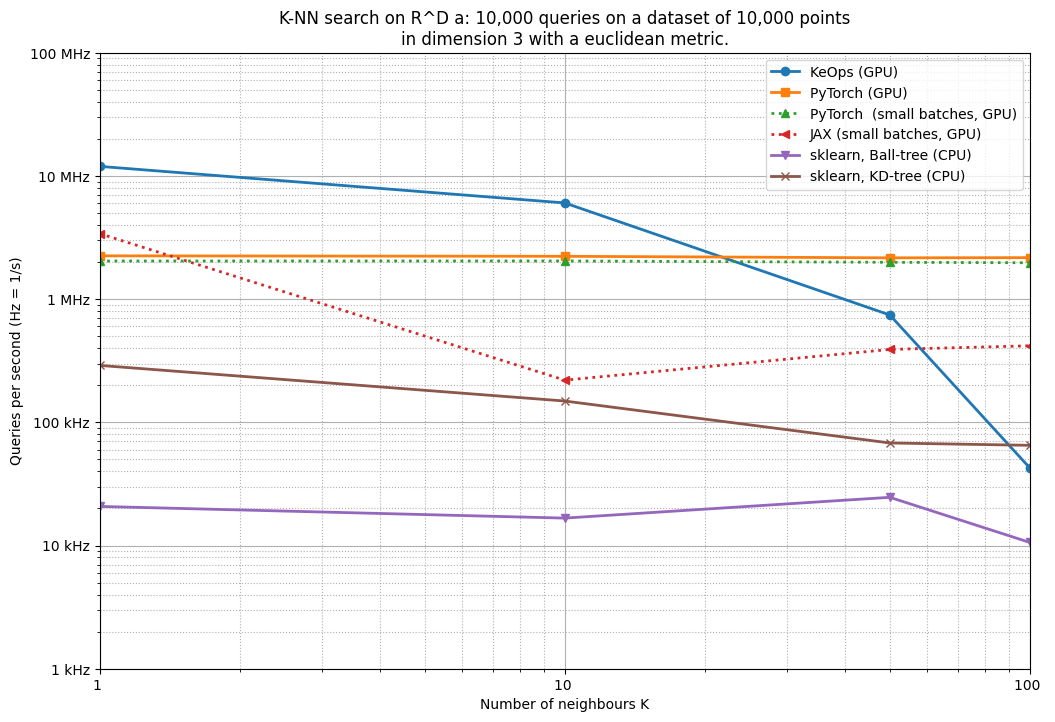

In [24]:
run_KNN_benchmark("R^D a", loops=[10, 1])

Large dataset of **1M points in dimension 3**, as is typical
in **computer graphics**.
In this setting, taking some time to create a multiscale
index of the input dataset can be worthwhile:
the IVF-Flat and HNSW methods provide **faster queries** at the cost
of significant **pre-processing times**.
Among "on-the-fly" bruteforce methods, KeOps edges
the FAISS-Flat routine and is the most competitive option.



In [ ]:
run_KNN_benchmark("R^D b")

Benchmarking : K-NN search on R^D b: 10,000 queries on a dataset of 1,000,000 points
in dimension 3 with a euclidean metric. ===============================
KeOps (GPU) -------------
  1x  1 loops of size    1 : train =   1x  1x 102.2 µs, test  =   1x  1x  37.8 ms, recall = 100%


Large dataset of **1M points in dimension 10**,
as can be typical in **low-dimensional machine learning**.
In this setting, approximate strategies such as the IVF-Flat method
are **most competitive** - and we would expect the IVF-PQ routines to perform
even better!

<div class="alert alert-info"><h4>Note</h4><p>We don't display CPU-based methods with pre-processing
  times longer than 60s, but stress that these routines can
  provide excellent performances in "offline" scenarios.</p></div>



In [ ]:
run_KNN_benchmark("R^D c")

Large dataset of **1M points in dimension 100**,
with **random Gaussian samples**.
Crucially, when the dataset is high-dimensional and has
little to no geometric structure, **bruteforce methods become relevant once again**:
FAISS-Flat and KeOps provide the only two reasonable run times.
As detailed in [our high-dimensional benchmarks](plot_benchmark_high_dimension.html),
the cuBLAS-based routines of FAISS edge our KeOps implementation
when the dimension of the ambient space D exceeds 50-100.

One of our top priorities for early 2021 is to close this gap
with improved CUDA schemes. Adding support for
some of the new hardware features of Ampere GPUs (Tensor cores,
quantized numerical types, etc.) should also help
to improve performances across the board.



In [ ]:
run_KNN_benchmark("R^D d")

## Random samples in other spaces

**Cosine similarity metric with 1M points in dimension 10**,
as can be typical in low-dimensional machine learning.
This metric is generally well-supported by standard libraries:
using efficient matrix-matrix products,
it is even easier to implement than the squared Euclidean distance.

Unsurprisingly, run times follow closely the trends
of the previous examples.
In dimension 10, approximate IVF-like strategies provide
the largest amount of queries per second.
KeOps remains competitive among bruteforce methods,
without any pre-processing time.



In [ ]:
run_KNN_benchmark("S^{D-1}")

The picture changes completely
once we start working with less common formulas
such as the **Manhattan-L1 metric**.
In this scenario, neither cuBLAS nor FAISS can be used and
KeOps remain the only competitive library for K-NN search on the GPU.
This is true with **1M points in dimension 10**:




In [ ]:
run_KNN_benchmark("R^D f")

**1M point in dimension 100**, or any other dataset:



In [ ]:
run_KNN_benchmark("R^D g")

The same lesson holds in e.g. hyperbolic spaces.
In the example below, we perform K-NN queries
for the hyperbolic metric with **1M points in the Poincare half-plane of dimension 10**.
The run times for KeOps remain in line with the "Euclidean" benchmarks
and **orders of magnitude faster** than standard PyTorch and JAX implementations.



In [ ]:
run_KNN_benchmark("H^D")

## Standard datasets

The benchmarks above were all performed on random Gaussian samples.
These results provide an informative baseline...
But in practice, most real-life datasets present a
**geometric structure** that can be leveraged by clever algorithms.
To measure the performances of bruteforce and IVF-like methods in
"realistic" machine learning scenarios, we now benchmark
our routines on several [standard datasets](https://ann-benchmarks.com).

First of all, on the well-known **MNIST collection of handwritten digits**:
a collection of 60k 28-by-28 images, encoded as vectors
of dimension 784 and endowed with the **Euclidean metric**.
This dataset is relatively **small** (less than 100k training samples)
but **high-dimensional** (D > 50) and highly **clustered** around
a dozen of prototypes (the digits 0, 1, ..., 9 and their variants).
Unsurprisingly, it is handled much more efficiently by the FAISS routines
than by our bruteforce KeOps implementation.




In [ ]:
run_KNN_benchmark("MNIST a")

Note, however, that KeOps remains the only viable option
to work easily with less common metrics such as the Manhattan-L1 norm:



In [ ]:
run_KNN_benchmark("MNIST b")

To conclude this benchmark, we evaluate our routines
on the [GloVe word embeddings](https://nlp.stanford.edu/projects/glove/)
for natural language processing:
**1.2M words**, represented as vectors of **dimension 25-100** and
compared with each other using the **cosine similarity metric**.

In dimension 25, KeOps performs on par with the FAISS-Flat bruteforce
routines. Both methods are slower than IVF-like algorithms
in terms of queries per second:



In [ ]:
run_KNN_benchmark("GloVe25")

In dimension 100, the pre-processing times associated
to IVF-like methods increase significantly while
the FAISS-Flat routine edges the KeOps engine
by a sizeable margin:



In [ ]:
run_KNN_benchmark("GloVe100")

plt.show()